# Imports

In [1]:
!pip install antropy

In [2]:
import pandas as pd
import numpy as np
import antropy as ant
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import os

# Carga datos

In [3]:
# s_05_03 = pd.read_csv('dataset/data/sub_05/rec_3.csv')
s_05_03 = pd.read_csv('rec_3.csv')
s_05_03.head()

,pelvis_x,pelvis_y,pelvis_z,L5_x,L5_y,L5_z,L3_x,L3_y,L3_z,T12_x,...,lowerLegLeft_z,footLeft_x,footLeft_y,footLeft_z,toeLeft_x,toeLeft_y,toeLeft_z,vel_x,vel_y,vel_z
0,10.825740,1.687339,0.901162,10.821957,1.688543,0.998533,10.801117,1.684932,1.103688,10.789364,...,0.489737,10.847054,1.590837,0.086303,10.690569,1.543336,0.040219,0.101791,0.048034,0.061909
1,10.826746,1.687909,0.901579,10.822491,1.689396,0.998923,10.801186,1.686003,1.103991,10.789015,...,0.490681,10.847797,1.591756,0.087400,10.691583,1.544044,0.040627,0.106294,0.052266,0.062296
2,10.827751,1.688479,0.901995,10.823026,1.690249,0.999314,10.801255,1.687074,1.104293,10.788665,...,0.491625,10.848540,1.592674,0.088496,10.692597,1.544752,0.041036,0.110797,0.056498,0.062684
3,10.828800,1.688855,0.902391,10.823661,1.690839,0.999687,10.801457,1.687831,1.104582,10.788469,...,0.492438,10.849213,1.593081,0.089413,10.693475,1.544821,0.041617,0.107863,0.051933,0.059625
4,10.829987,1.688930,0.902780,10.824518,1.691051,1.000055,10.801913,1.688148,1.104867,10.788529,...,0.493119,10.849844,1.592494,0.090127,10.694226,1.543555,0.042641,0.090787,0.030129,0.052072


# Corelación entre datos

## Visualizar correlaciones

In [ ]:
corrs = s_05_03[s_05_03.columns[:18]].corr()
datos = s_05_03.iloc[:, :18]
sns.heatmap(corrs)
sns.pairplot(s_05_03[s_05_03.columns[:18]])

## Restar la posición de la pelvis

In [4]:
resta = s_05_03.copy()
for i in range(3):
  resta.iloc[:,3+i:3]-= s_05_03.iloc[:,i:i+1].to_numpy()
resta.shape

(4089, 72)

# Visualizar

In [ ]:
def visualizar(datos):
  fig = px.scatter_3d(
    datos, x='pelvis_x', y='pelvis_y', z='pelvis_z'
  )
  fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
  fig.show()
def visualizar_animado(x,y,z):
  fig = go.Figure(
    data=[go.Scatter3d(x=[], y=[], z=[],
                     mode="markers",marker=dict(color="red", size=2))])
  fig.update_layout(
         scene = dict(
        xaxis=dict(range=[min(x), max(x)], autorange=False),
        yaxis=dict(range=[min(y), max(y)], autorange=False),
        zaxis=dict(range=[min(z), max(z)], autorange=False),
        )),
  frames = [go.Frame(data= [go.Scatter3d(
                                       x=x[[k]],
                                       y=y[[k]],
                                       z=z[[k]])],

                   traces= [0],
                   name=f'frame{k}'
                  )for k  in  range(len(x))]
  fig.update(frames=frames),

  fig.update_layout(updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, dict(frame=dict(redraw=True,fromcurrent=True, mode='immediate'))])])])
  fig.show()
def visualizar2d(datos):
  fig = px.scatter(datos,x=0, y=1, labels={'0': 'pelvis_x', '1': 'pelvis_y'})
  fig.update_traces(marker=dict(size=2),
              selector=dict(mode='markers'))
  fig.show()
def matplote(datosx, datosy,datosz):
  fig = plt.figure()
  ax = plt.axes(projection ='3d')
  ax.scatter3D(datosx,datosy, datosz)
  plt.show
datos = [resta["pelvis_x"],resta["pelvis_y"],resta["pelvis_z"]]
#datos = np.array(datos)
matplote(resta["pelvis_x"],resta["pelvis_y"],resta["pelvis_z"])
visualizar(resta)
visualizar_animado(resta["pelvis_x"],resta["pelvis_y"],resta["pelvis_z"])
#visualizar2d([resta["pelvis_x"],resta["pelvis_y"]])



# Normalización
Normalización de los puntos

In [5]:
stnd_scaler = preprocessing.StandardScaler()
df_stnd = stnd_scaler.fit_transform(resta)

min_max_scaler = preprocessing.MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(resta)
df_normalizado = df_stnd
type(df_minmax)

numpy.ndarray

# Ventaneo
Dividir los datos en fragmentos de 4 segundos

In [6]:
freq =60
segundos =4
ventana = freq*segundos
ventanal = []
for i in range (0, len(df_normalizado)- ventana+1, ventana):
  ventanal.append(df_normalizado[i:i+ventana])
ventanal = np.array(ventanal)
ventanal.shape

(17, 240, 72)

# Extracción de características

## Media

In [7]:
medias = ventanal.mean(axis=1)
medias.shape

(17, 72)

## Desviación típica

In [8]:
desviaciones = ventanal.std(axis=1)
desviaciones.shape

(17, 72)

## Mínimo y máximo

### Mínimo

In [9]:
minimos = ventanal.min(axis = 1)
minimos.shape

(17, 72)

### Máximo

In [10]:
maximos = ventanal.max(axis = 1)
maximos.shape

(17, 72)

## Energía de la señal

In [11]:
ventanalcuadrado = ventanal ** 2
energia = ventanalcuadrado.sum(axis = 1)
energia.shape

(17, 72)

## Parámetros de Hjorth

In [12]:
mobility, complexity = ant.hjorth_params(ventanal, 1)
activity = ventanal.var(axis =1)
activity.shape
mobility.shape
complexity.shape

(17, 72)

# Juntar las características

In [13]:
nombres_base = s_05_03.columns
nombres_media = [s + "_med" for s in nombres_base]
nombres_desviacion = [s + "_desv" for s in nombres_base]
nombres_minimo = [s + "_min" for s in nombres_base]
nombres_maximo =  [s + "_max" for s in nombres_base]
nombres_energia = [s + "_ener" for s in nombres_base]
nombres_actividad = [s + "_act" for s in nombres_base]
nombres_movilidad = [s + "_mov" for s in nombres_base]
nombres_complejidad = [s + "_comp" for s in nombres_base]
cols = [
    *nombres_media,
    *nombres_desviacion,
    *nombres_minimo,
    *nombres_maximo,
    *nombres_energia,
    *nombres_actividad,
    *nombres_movilidad,
    *nombres_complejidad,
]
medias_reshaped = medias.reshape(-1, medias.shape[-1])
desviaciones_reshaped = desviaciones.reshape(-1, desviaciones.shape[-1])
minimos_reshaped = minimos.reshape(-1, minimos.shape[-1])
maximos_reshaped = maximos.reshape(-1, maximos.shape[-1])
energia_reshaped = energia.reshape(-1, energia.shape[-1])
activity_reshaped = activity.reshape(-1, activity.shape[-1])
mobility_reshaped = mobility.reshape(-1, mobility.shape[-1])
complexity_reshaped = complexity.reshape(-1, complexity.shape[-1])
arrays = [medias_reshaped, desviaciones_reshaped, minimos_reshaped, maximos_reshaped,
          energia_reshaped, activity_reshaped, mobility_reshaped, complexity_reshaped]
stacked_array = np.concatenate(arrays, axis=1)

df = pd.DataFrame(stacked_array, columns=cols)
df

,pelvis_x_med,pelvis_y_med,pelvis_z_med,L5_x_med,L5_y_med,L5_z_med,L3_x_med,L3_y_med,L3_z_med,T12_x_med,...,lowerLegLeft_z_comp,footLeft_x_comp,footLeft_y_comp,footLeft_z_comp,toeLeft_x_comp,toeLeft_y_comp,toeLeft_z_comp,vel_x_comp,vel_y_comp,vel_z_comp
0,1.840494,-0.921295,0.644375,1.840641,-0.921046,0.651539,1.838669,-0.921371,0.606530,1.838146,...,1.514114,4.513065,9.380492,1.855509,4.531740,7.722284,1.724486,9.217163,3.663658,1.912481
1,1.284390,-1.000921,0.073700,1.285440,-1.000611,0.069333,1.284341,-1.000682,0.082240,1.284650,...,1.526653,7.607912,10.533241,1.795690,7.338953,7.826181,1.754198,2.012677,2.272298,2.255875
2,0.647000,-1.074063,0.008660,0.648021,-1.073823,0.003130,0.646946,-1.073809,0.018569,0.647340,...,1.465396,7.626872,10.534859,1.708394,7.168565,7.152250,1.755084,2.248862,3.420153,2.120138
3,0.054967,-0.970471,-0.064944,0.055800,-0.970639,-0.066215,0.054563,-0.969850,-0.063615,0.054671,...,1.549616,7.789412,6.946167,1.678812,6.765756,7.281909,1.690871,2.378690,3.772426,2.289610
4,-0.477402,-0.578637,0.010067,-0.476764,-0.579110,0.009820,-0.477601,-0.578049,0.020103,-0.477315,...,1.486068,8.253517,7.500895,1.802289,7.316899,7.426529,1.734891,2.567891,2.669262,2.373486
5,-0.869511,-0.044014,-0.106879,-0.868991,-0.044540,-0.106557,-0.869690,-0.043007,-0.106602,-0.869594,...,1.511547,8.796820,7.267973,1.655590,7.195288,6.859287,1.732947,3.057450,2.484697,2.167701
6,-1.117993,0.580884,-0.097383,-1.117724,0.580304,-0.095671,-1.118098,0.581974,-0.094178,-1.117915,...,1.568735,10.570389,7.695107,1.831912,8.557816,7.182056,1.697059,2.367540,2.191528,2.336348
7,-1.126386,1.201004,-0.061346,-1.126339,1.200383,-0.061960,-1.125401,1.201779,-0.066131,-1.125036,...,1.606248,6.112820,7.862905,1.744221,7.170140,6.872590,1.784725,6.313459,2.576361,2.139306
8,-0.765136,1.755375,-0.069196,-0.765670,1.754644,-0.075290,-0.764994,1.755468,-0.056943,-0.765237,...,1.610522,5.646669,8.332626,1.626350,5.908580,7.446311,1.716152,2.367265,4.762919,2.309683
9,-0.477169,1.835827,0.020972,-0.477830,1.836274,0.018043,-0.478371,1.835235,0.013918,-0.479055,...,1.753900,2.302487,7.115402,1.799338,2.440650,6.923815,1.805630,10.177129,5.960166,2.155387


#  Elección de algoritmo

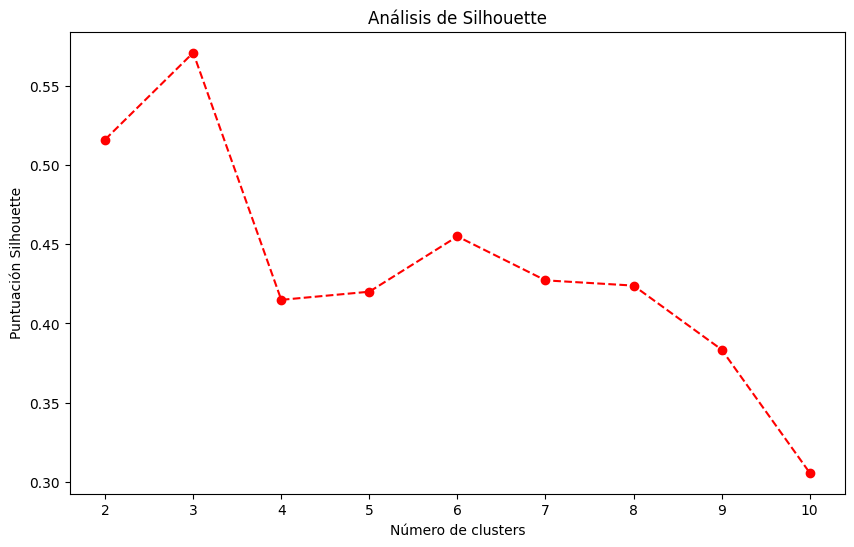

In [14]:
# evaluación Silhouette para KMeans
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='r')
plt.title('Análisis de Silhouette')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación Silhouette')
plt.show()

# Interpretación de resultados

##Resumen

## Visualización